# Laboratorio 7 CartPole
## Deep Learning

- Fabiola Contreras, 22787
- Diego Duarte, 22075
- José Marchena, 22398
- Sofía Velásquez, 22049
- María José Villafuerte, 22129

### Preparar ambiente

In [5]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import pygame

c:\Users\villa\Desktop\Clases_S8\6.Deep Learning y Sistemas Inteligentes\6.Lab7\CartPole_DL\gymnasium\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [6]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

### Definición de Redes

In [7]:
class QNetwork(nn.Module):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        
    def forward(self, x):
        return self.net(x)

In [8]:
obs_size = env.observation_space.shape[0]   # 4 observaciones
n_actions = env.action_space.n              # 2 acciones

# Red en línea
online_net = QNetwork(obs_size, n_actions)

# Red de destino (clon inicial)
target_net = QNetwork(obs_size, n_actions)
target_net.load_state_dict(online_net.state_dict())  # mismos pesos al inicio
target_net.eval()  # no necesita gradientes

QNetwork(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

### Establecer hiperparámetros

In [9]:
import random
from collections import deque
import torch.optim as optim

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
online_net.to(device)
target_net.to(device)

# Hiperparámetros principales
GAMMA = 0.99                 # factor de descuento
LR = 1e-3                    # tasa de aprendizaje
BATCH_SIZE = 64              # tamaño de minibatch
REPLAY_CAPACITY = 50_000     # capacidad del buffer
TARGET_UPDATE_FREQ = 1000    # cada cuántos pasos copiar (hard update) a la red objetivo
TRAIN_START_SIZE = 1000      # mínimo de transiciones antes de entrenar
MAX_EPISODES = 500           # por si lo usas luego en el bucle de entrenamiento
MAX_STEPS_PER_EP = 500

# Exploración ε-greedy
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY_STEPS = 50_000     # pasos para decaer desde 1.0 -> 0.05 (lineal)

# Optimizador y pérdida
optimizer = optim.Adam(online_net.parameters(), lr=LR)
criterion = nn.MSELoss()

# Programador lineal de epsilon (por pasos globales)
global_step = 0
def get_epsilon(step: int) -> float:
    # decaimiento lineal
    frac = min(1.0, step / EPS_DECAY_STEPS)
    return EPS_START + (EPS_END - EPS_START) * frac

### Selección de acciones épsilon-greedy

In [10]:
def select_action(state_np, epsilon: float):
    """
    state_np: np.ndarray con forma (obs_size,)
    epsilon : valor actual de exploración
    Retorna: acción (int)
    """
    if random.random() < epsilon:
        # Explora
        return env.action_space.sample()
    else:
        # Explotación con la red online
        state_t = torch.as_tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)  # [1, obs_size]
        with torch.no_grad():
            q_values = online_net(state_t)  # [1, n_actions]
            action = int(torch.argmax(q_values, dim=1).item())
        return action


### Experience replay

In [11]:
# Replay Buffer + paso de optimización (DQL con red objetivo) muy de girly pop
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buf = deque(maxlen=capacity)
    def push(self, s, a, r, s_next, done):
        # Guardamos como tuplas
        self.buf.append((s, a, r, s_next, done))
    def __len__(self):
        return len(self.buf)
    def sample(self, batch_size: int):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s_next, d = zip(*batch)

        s      = torch.as_tensor(np.vstack(s), dtype=torch.float32, device=device)      # [B, obs]
        a      = torch.as_tensor(a, dtype=torch.int64, device=device).unsqueeze(1)      # [B, 1]
        r      = torch.as_tensor(r, dtype=torch.float32, device=device).unsqueeze(1)    # [B, 1]
        s_next = torch.as_tensor(np.vstack(s_next), dtype=torch.float32, device=device) # [B, obs]
        d      = torch.as_tensor(d, dtype=torch.float32, device=device).unsqueeze(1)    # [B, 1]

        return s, a, r, s_next, d


replay = ReplayBuffer(REPLAY_CAPACITY)

def hard_update_target():
    """Copia dura de pesos desde online_net hacia target_net."""
    target_net.load_state_dict(online_net.state_dict())

def optimize_model():
    """Un paso de optimización DQL usando muestras del replay + red objetivo."""
    if len(replay) < max(BATCH_SIZE, TRAIN_START_SIZE):
        return None  # aún no hay suficientes muestras

    # Muestra minibatch
    states, actions, rewards, next_states, dones = replay.sample(BATCH_SIZE)

    # Q_online(s, a): tomamos sólo el Q de la acción ejecutada
    q_pred_all = online_net(states)                       # [B, n_actions]
    q_pred = q_pred_all.gather(1, actions)                # [B, 1]

    # Objetivo con red objetivo: y = r + gamma * (1 - done) * max_a' Q_target(s', a')
    with torch.no_grad():
        q_next_all = target_net(next_states)              # [B, n_actions]
        q_next_max = q_next_all.max(dim=1, keepdim=True).values  # [B, 1]
        q_target = rewards + (1.0 - dones) * GAMMA * q_next_max  # [B, 1]

    # Pérdida MSE
    loss = criterion(q_pred, q_target)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    # por si nos sirve, este es un clipping de gradiente para estabilidad, si no lo podemos borrar, x no importa
    torch.nn.utils.clip_grad_norm_(online_net.parameters(), max_norm=10.0)
    optimizer.step()

    return loss.item()


### Training Cycle y Visualizar Entorno

In [12]:
# Crear entorno con renderizado en pantalla
env = gym.make("CartPole-v1", render_mode="human")  

reward_history = []
loss_history = []

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    total_reward = 0

    for t in range(MAX_STEPS_PER_EP):
        global_step += 1
        epsilon = get_epsilon(global_step)

        # Renderizar cada 50 episodios
        if episode % 50 == 0:
            env.render()

        # Selección de acción (ε-greedy)
        action = select_action(state, epsilon)

        # Ejecutar acción en el entorno
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # Guardar transición en el buffer con dtype correcto
        replay.push(
            np.array(state, dtype=np.float32), 
            action, 
            reward, 
            np.array(next_state, dtype=np.float32), 
            done
        )

        # Optimizar modelo con un batch de replay
        loss = optimize_model()
        if loss is not None:
            loss_history.append(loss)

        # Actualizar red objetivo cada cierto número de pasos
        if global_step % TARGET_UPDATE_FREQ == 0:
            hard_update_target()

        state = next_state

        if done:
            break

    reward_history.append(total_reward)

    # Log de progreso cada 10 episodios
    if (episode + 1) % 10 == 0:
        avg_r = np.mean(reward_history[-10:])
        print(f"Ep {episode+1}/{MAX_EPISODES} | Recompensa media ult.10: {avg_r:.2f} | ε={epsilon:.3f}")

# Cerrar entorno al final
env.close()


Ep 10/500 | Recompensa media ult.10: 22.90 | ε=0.996
Ep 20/500 | Recompensa media ult.10: 18.90 | ε=0.992
Ep 30/500 | Recompensa media ult.10: 27.80 | ε=0.987
Ep 40/500 | Recompensa media ult.10: 20.90 | ε=0.983
Ep 50/500 | Recompensa media ult.10: 22.20 | ε=0.979
Ep 60/500 | Recompensa media ult.10: 23.60 | ε=0.974
Ep 70/500 | Recompensa media ult.10: 25.80 | ε=0.969
Ep 80/500 | Recompensa media ult.10: 17.20 | ε=0.966
Ep 90/500 | Recompensa media ult.10: 15.60 | ε=0.963
Ep 100/500 | Recompensa media ult.10: 19.30 | ε=0.959
Ep 110/500 | Recompensa media ult.10: 18.50 | ε=0.956
Ep 120/500 | Recompensa media ult.10: 21.30 | ε=0.952
Ep 130/500 | Recompensa media ult.10: 24.30 | ε=0.947
Ep 140/500 | Recompensa media ult.10: 22.30 | ε=0.943
Ep 150/500 | Recompensa media ult.10: 19.10 | ε=0.939
Ep 160/500 | Recompensa media ult.10: 20.10 | ε=0.935
Ep 170/500 | Recompensa media ult.10: 29.70 | ε=0.930
Ep 180/500 | Recompensa media ult.10: 23.80 | ε=0.925
Ep 190/500 | Recompensa media ult.10:

### Gráfica de monitoreo del entrenamiento


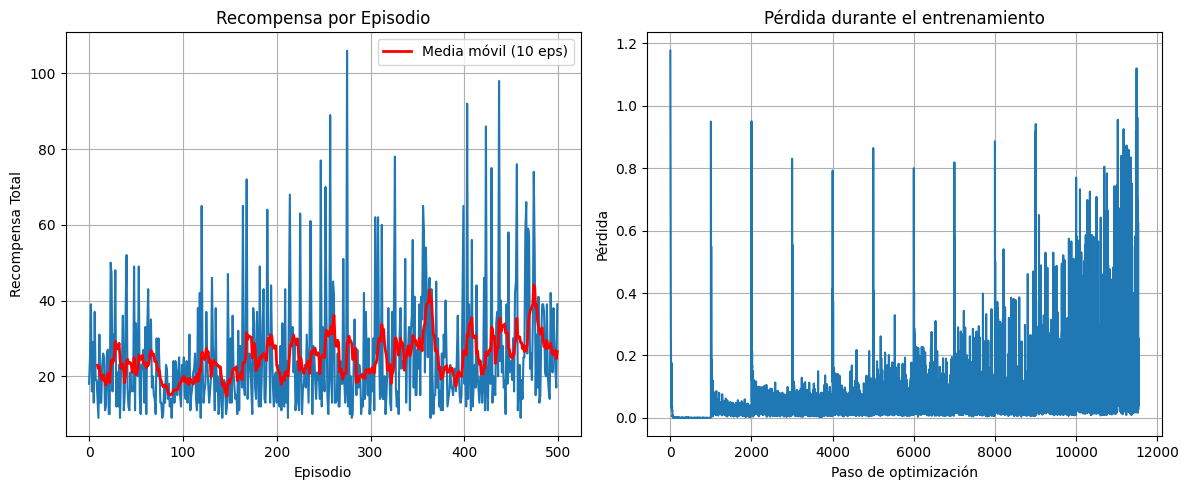

In [15]:
import matplotlib.pyplot as plt

# Graficar recompensas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reward_history)
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Recompensa por Episodio')
plt.grid(True)

# Media móvil para suavizar la curva
window = 10
if len(reward_history) >= window:
    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(reward_history)), moving_avg, 'r-', linewidth=2, label=f'Media móvil ({window} eps)')
    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.xlabel('Paso de optimización')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluación del agente entrenado


In [17]:
# Evaluación del agente entrenado
def evaluate_agent(env, net, n_episodes=10, max_steps=500):
    """
    Evalúa el agente entrenado sin exploración
    """
    eval_rewards = []
    
    for ep in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # Sin exploración (epsilon = 0)
            state_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                q_values = net(state_t)
                action = int(torch.argmax(q_values, dim=1).item())
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        eval_rewards.append(total_reward)
        print(f"Episodio de evaluación {ep+1}/{n_episodes}: Recompensa = {total_reward}")
    
    return eval_rewards

# Crear entorno de evaluación (sin render)
eval_env = gym.make("CartPole-v1")

print("\n" + "="*50)
print("Evaluacion del agente entrenado")
print("="*50)

eval_rewards = evaluate_agent(eval_env, online_net, n_episodes=10)

print(f"\nRecompensa promedio: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"Recompensa máxima: {np.max(eval_rewards)}")
print(f"Recompensa mínima: {np.min(eval_rewards)}")

eval_env.close()


Evaluacion del agente entrenado
Episodio de evaluación 1/10: Recompensa = 283.0
Episodio de evaluación 2/10: Recompensa = 105.0
Episodio de evaluación 3/10: Recompensa = 425.0
Episodio de evaluación 4/10: Recompensa = 402.0
Episodio de evaluación 5/10: Recompensa = 401.0
Episodio de evaluación 6/10: Recompensa = 493.0
Episodio de evaluación 7/10: Recompensa = 376.0
Episodio de evaluación 8/10: Recompensa = 124.0
Episodio de evaluación 9/10: Recompensa = 388.0
Episodio de evaluación 10/10: Recompensa = 317.0

Recompensa promedio: 331.40 ± 121.13
Recompensa máxima: 493.0
Recompensa mínima: 105.0
